In [134]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [135]:
warnings.filterwarnings("ignore")

In [136]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [137]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [138]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [139]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 180) #6 meses
            i += 1
        return df

In [140]:
def group_by_month(df, date_column, value_column):
    df[date_column] = pd.to_datetime(df[date_column], format='%d/%m/%Y')
    df['Ano'] = df[date_column].dt.strftime('%m/%Y')
    result = df.groupby('Ano')[value_column].mean()
    result_df = result.reset_index()
    result_df['Ano'] = pd.to_datetime(result_df['Ano'], format='%m/%Y')
    result_df = result_df.sort_values(by='Ano')

    return result_df

In [141]:
df = read_csv_replace_missing_by_polynomial('embi_risco_brasil.csv', 0, 0)
df

,Ano,EMBI + Risco-Brasil
0,18/10/2023,234.127072
1,17/10/2023,234.451248
2,16/10/2023,234.790045
3,13/10/2023,235.088959
4,12/10/2023,235.353823
...,...,...
7557,05/05/1994,340.893137
7558,04/05/1994,342.351274
7559,03/05/1994,343.831633
7560,02/05/1994,345.334535


In [142]:
df_month = group_by_month(df, 'Ano', 'EMBI + Risco-Brasil')
df_month

,Ano,EMBI + Risco-Brasil
87,1994-04-01,346.860129
117,1994-05-01,331.623844
147,1994-06-01,307.334289
177,1994-07-01,289.389771
207,1994-08-01,299.944688
...,...,...
176,2023-06-01,254.155724
206,2023-07-01,250.281267
236,2023-08-01,245.301880
266,2023-09-01,240.194680


In [143]:
def format_month_year(df_to_Change):
    df_to_Change['Ano'] = df_to_Change['Ano'].dt.strftime('%Y-%m')
    df_to_Change['Ano'] = df_to_Change['Ano'].str.split('-').str[0]
    return df_to_Change

df_month = format_month_year(df_month)
df_month['Ano'] = pd.to_numeric(df_month['Ano'], errors='coerce', downcast='integer')
df_mo_2003 = df_month[df_month['Ano'] >= 2003] 
df_mo_2003

,Ano,EMBI + Risco-Brasil
8,2003,231.510748
37,2003,208.710157
66,2003,227.704841
96,2003,278.121073
126,2003,344.827633
...,...,...
176,2023,254.155724
206,2023,250.281267
236,2023,245.301880
266,2023,240.194680


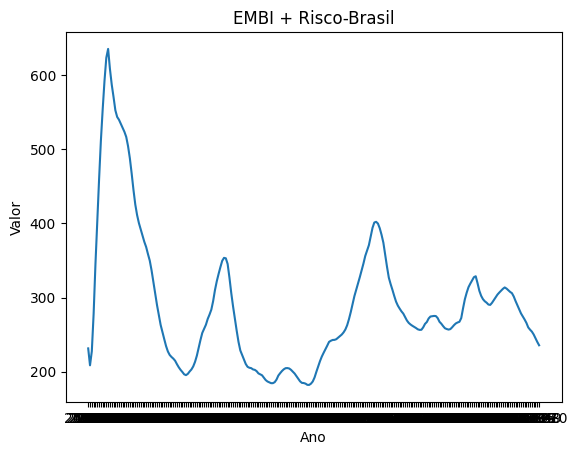

,EMBI + Risco-Brasil
2003-1,231.510748
2003-2,208.710157
2003-3,227.704841
2003-4,278.121073
2003-5,344.827633
...,...
2023-6,254.155724
2023-7,250.281267
2023-8,245.301880
2023-9,240.194680


In [144]:
import re

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
#         corrected_index = re.sub(r'\.\d{1,2}', '', index_value)
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_mo_2003.set_index('Ano', inplace=True)
df_mo_2003 = correct_index(df_mo_2003)
plot_columns(df_mo_2003)
df_mo_2003

In [145]:
df_mo_2003.to_csv('2003_mo_embi_risco_brasil.csv', index=True)